# Example: MNIST Data Set -  Auto Encoder

This is an extension of the [Notebook 1 Tutotial](https://github.com/clonker/bms-summerschool19-tf/blob/master/bms-tensorflow-tutorial-1.ipynb).

[Autoencoder (wiki)](https://en.wikipedia.org/wiki/Autoencoder)

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Load + Prepare Data

Let us prepare the data as in the [previous](https://github.com/juanitorduz/math_deep_learning_summer_school19/blob/master/keras/mnist_sequential.ipynb) notebook.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

Let us see the shape of the training data:

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1024).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1024).batch(batch_size)

## Class Definition

We can use the `tf.keras.Model` (see [documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model)):

- `__init__`: defines the layers.
- `call` defines the model's forward pass.

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(
            units=latent_dim, activation=tf.nn.relu, input_shape=(None, 28, 28,))
    
    def call(self, inputs):
        flat = tf.reshape(inputs, shape=[-1, 28*28])
        latent = self.dense(flat)
        return latent

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = tf.keras.layers.Dense(
            units=28*28, activation=tf.nn.relu, input_shape=(None, latent_dim)) 
    
    def call(self, inputs):
        flat = self.dense(inputs)
        image = tf.reshape(flat, [-1, 28, 28])
        return image

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

In [8]:
dim = 10
ae = Autoencoder(dim)
ae.build(input_shape=(batch_size, 28, 28))

ae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  7850      
_________________________________________________________________
decoder (Decoder)            multiple                  8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


Let us verify the number of parameters:

- Encoder

In [9]:
# We compute the number of weights and add bias.
dim*(28*28) + dim*1

7850

- Decoder

In [10]:
# We compute the number of weights and add bias.
(28*28)*dim + (28*28)

8624

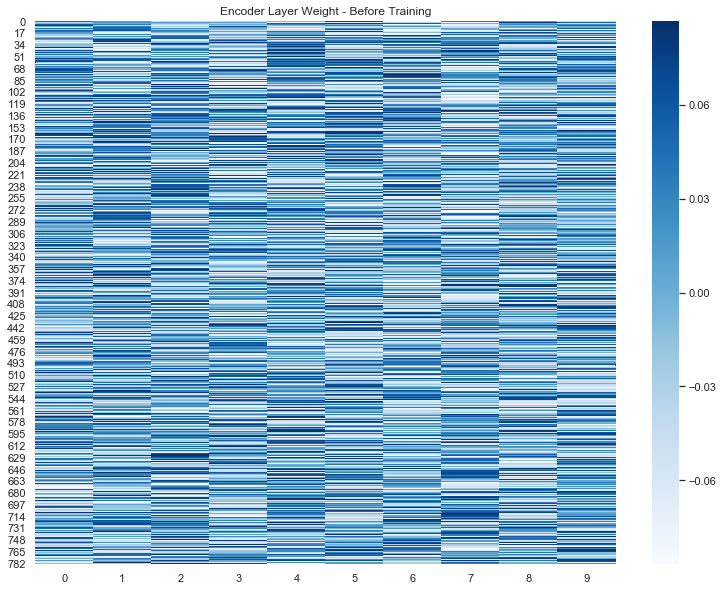

In [11]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(ae.weights[0].numpy(), ax=ax, cmap="Blues")
ax.set(title='Encoder Layer Weight - Before Training');

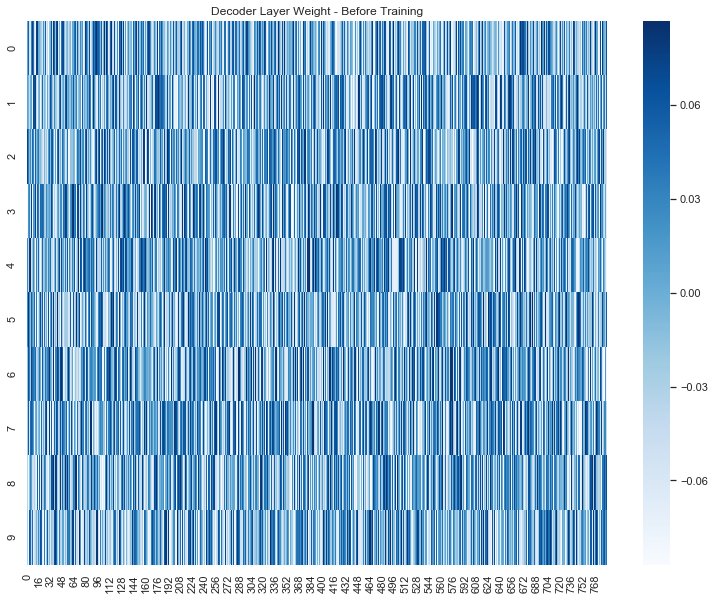

In [12]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(ae.weights[2].numpy(), ax=ax, cmap="Blues")
ax.set(title='Decoder Layer Weight - Before Training');

## Train Model

In [13]:
model_history = ae.fit(
    train_ds, 
    epochs=6, 
    validation_data=test_ds
)

Epoch 1/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0403 - mean_squared_error: 0.0486 - val_loss: 0.0361 - val_mean_squared_error: 0.0362
Epoch 2/6
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0358 - mean_squared_error: 0.0357 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 3/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0356 - mean_squared_error: 0.0355 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 4/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0356 - mean_squared_error: 0.0355 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 5/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0356 - mean_squared_error: 0.0355 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 6/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0355 - mean_squared_error: 0.0354 - val_loss: 0.0356 - val_mean_squared_error: 0.0356


## Model Weights 

Let us plot the final weigth values after training:

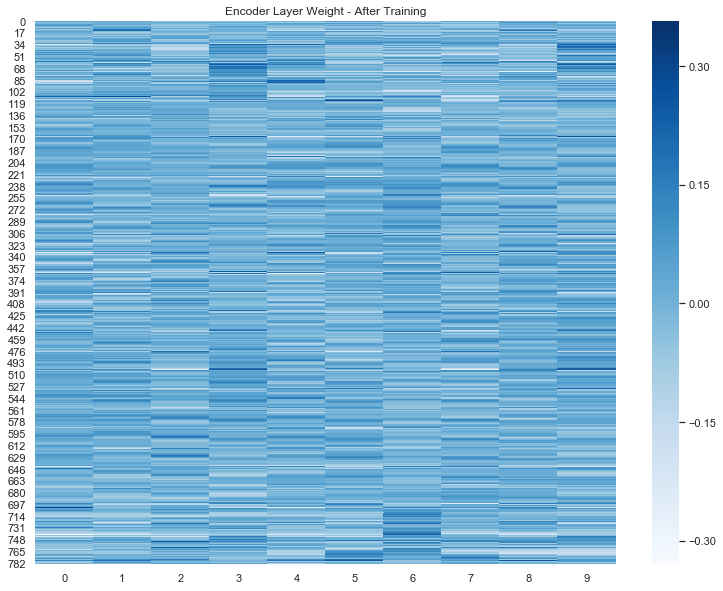

In [14]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(ae.weights[0].numpy(), ax=ax, cmap="Blues")
ax.set(title='Encoder Layer Weight - After Training');

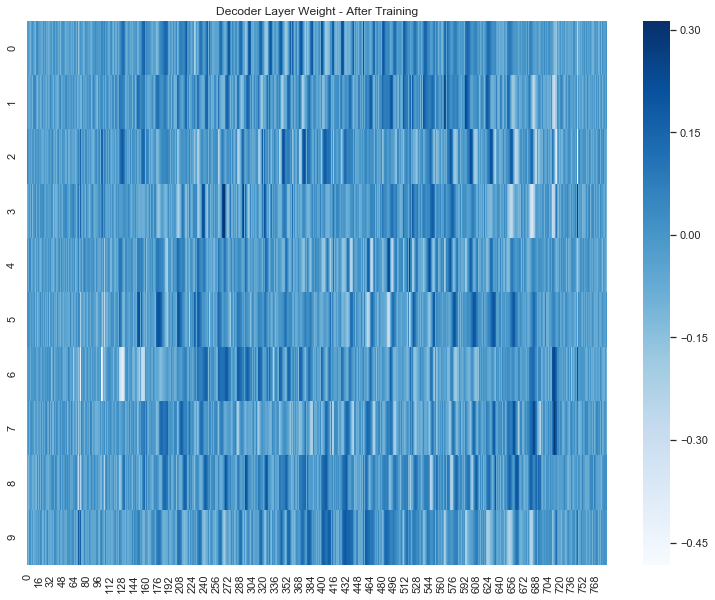

In [15]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(ae.weights[2].numpy(), ax=ax, cmap="Blues")
ax.set(title='Decoder Layer Weight - After Training');

## Model Evaluation

In [16]:
# Store history in a data frame. 
hist_df = pd.DataFrame(model_history.history)
hist_df['epoch'] = model_history.epoch

hist_df

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
0,0.040301,0.040300,0.036148,0.036158,0
1,0.035783,0.035783,0.035750,0.035760,1
2,0.035649,0.035649,0.035664,0.035673,2
3,0.035600,0.035600,0.035627,0.035636,3
4,0.035570,0.035570,0.035596,0.035605,4
5,0.035549,0.035549,0.035569,0.035578,5


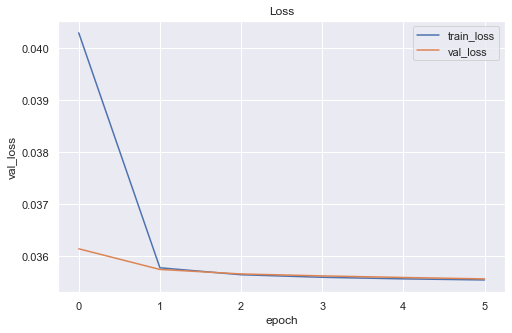

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x='epoch', y='loss', data=hist_df, ax=ax, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=hist_df, ax=ax, label='val_loss')
ax.set(title='Loss')
ax.legend(loc='upper right');

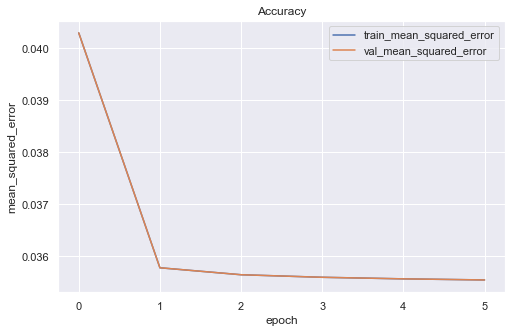

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x='epoch', y='mean_squared_error', data=hist_df, ax=ax, label='train_mean_squared_error')
sns.lineplot(x='epoch', y='mean_squared_error', data=hist_df, ax=ax, label='val_mean_squared_error')
ax.set(title='Accuracy')
ax.legend(loc='upper right');

In [19]:
ae.evaluate(test_ds)

313/313 [==============================] - 0s 753us/step - loss: 0.0356 - mean_squared_error: 0.0356


[0.0355688028882582, 0.035578102]

## Autoencoder Predictions

Let us plot the autoencoder predictions for the a batch in the training set.

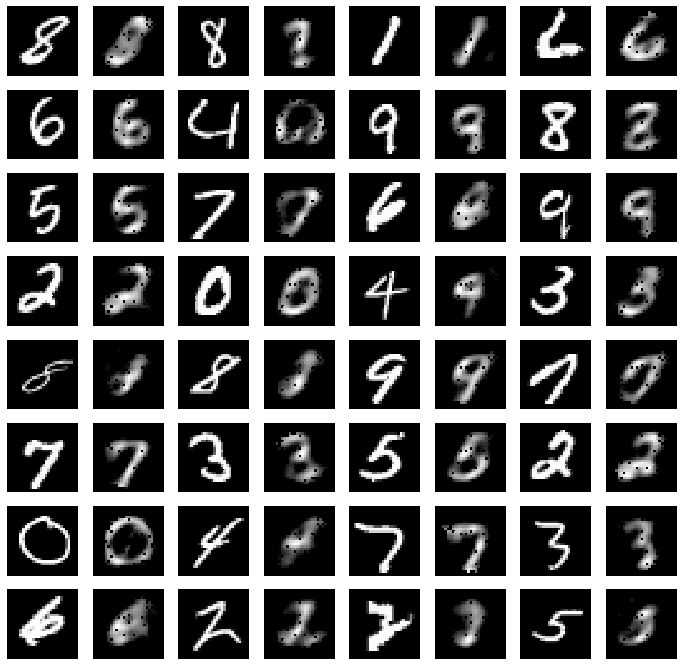

In [20]:
for images, _ in train_ds.take(1):
    # Get total number of images ini a batch. 
    n_images = len(images)
    # Set plot grid dimensions:
    n_cols = 8
    n_rows = 2*n_images // n_cols
    
    # Generate model predictions.
    predictions = ae.call(images)
    
    # Define figure structure.
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*1.5,n_rows*1.5))
    axes = axes.flatten()
    
    for i, image in enumerate(images):
        # Define axis.
        ax_image = axes[2*i]
        ax_pred = axes[2*i+1]
        # Plot predictions.
        sns.heatmap(data=image, cmap='gist_gray', cbar=False, ax=ax_image)
        sns.heatmap(data=predictions[i], cmap='gist_gray', cbar=False, ax=ax_pred)
        # Customize plot.
        ax_image.set(xticks=[], yticks=[])
        ax_pred.set(xticks=[], yticks=[])

Let us do the same for the test set:

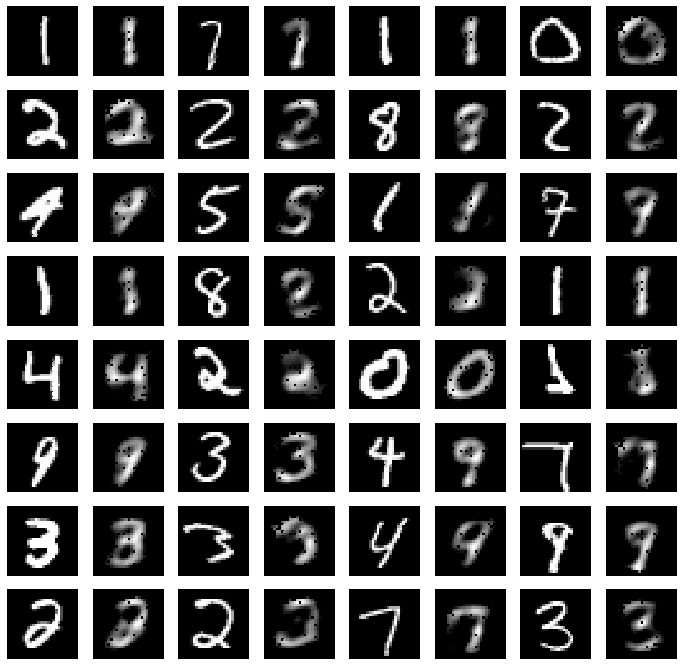

In [21]:
for images, _ in test_ds.take(1):
    # Get total number of images ini a batch. 
    n_images = len(images)
    # Set plot grid dimensions:
    n_cols = 8
    n_rows = 2*n_images // n_cols
    
    # Generate model predictions.
    predictions = ae.call(images)
    
    # Define figure structure.
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*1.5,n_rows*1.5))
    axes = axes.flatten()
    
    for i, image in enumerate(images):
        # Define axis.
        ax_image = axes[2*i]
        ax_pred = axes[2*i+1]
        # Plot predictions.
        sns.heatmap(data=image, cmap='gist_gray', cbar=False, ax=ax_image)
        sns.heatmap(data=predictions[i], cmap='gist_gray', cbar=False, ax=ax_pred)
        # Customize plot.
        ax_image.set(xticks=[], yticks=[])
        ax_pred.set(xticks=[], yticks=[])